In [19]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import librosa
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LayerNormalization, BatchNormalization, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio
cmap = mpl.cm.get_cmap('coolwarm')

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.18.0
Keras: 3.6.0
KerasCV: 0.9.0


### Config

In [2]:
class CFG:
    random_seed = 42

    # Audio config
    mfcc_features = 64
    mfcc_length = 1000

    # Class Labels for BirdCLEF 24
    class_names = sorted([
        folder for folder in os.listdir("birdclef-2024/train_audio") 
        if os.path.isdir(os.path.join("birdclef-2024/train_audio", folder)) and not folder.startswith('.')
    ])
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

### Data Preprocessing

#### Load from file

In [3]:

BASE_PATH = "/Users/visheshgoyal/Desktop/DS301/Project/birdclef-2024"

df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,XC134896.ogg,/Users/visheshgoyal/Desktop/DS301/Project/bird...,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,XC164848.ogg,/Users/visheshgoyal/Desktop/DS301/Project/bird...,0,XC164848


#### Load and display sample audio with Librosa

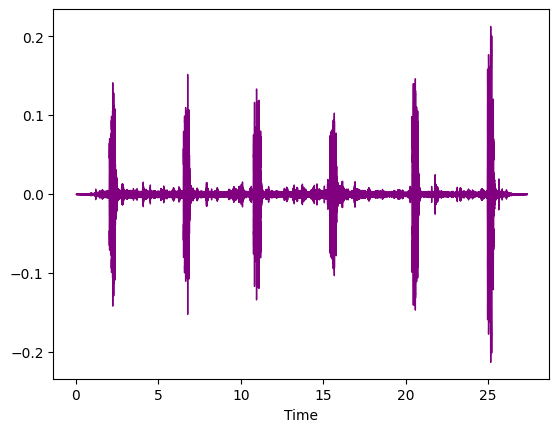

In [4]:
sample_num=0 #pick a file to display

audio,sr=librosa.load(df.iloc[sample_num].filepath)
librosa.display.waveshow(audio,sr=sr, x_axis='time', color='purple',offset=0.0)

#### Extract example and show Mel-frequency cepstral coefficients (MFCCs)

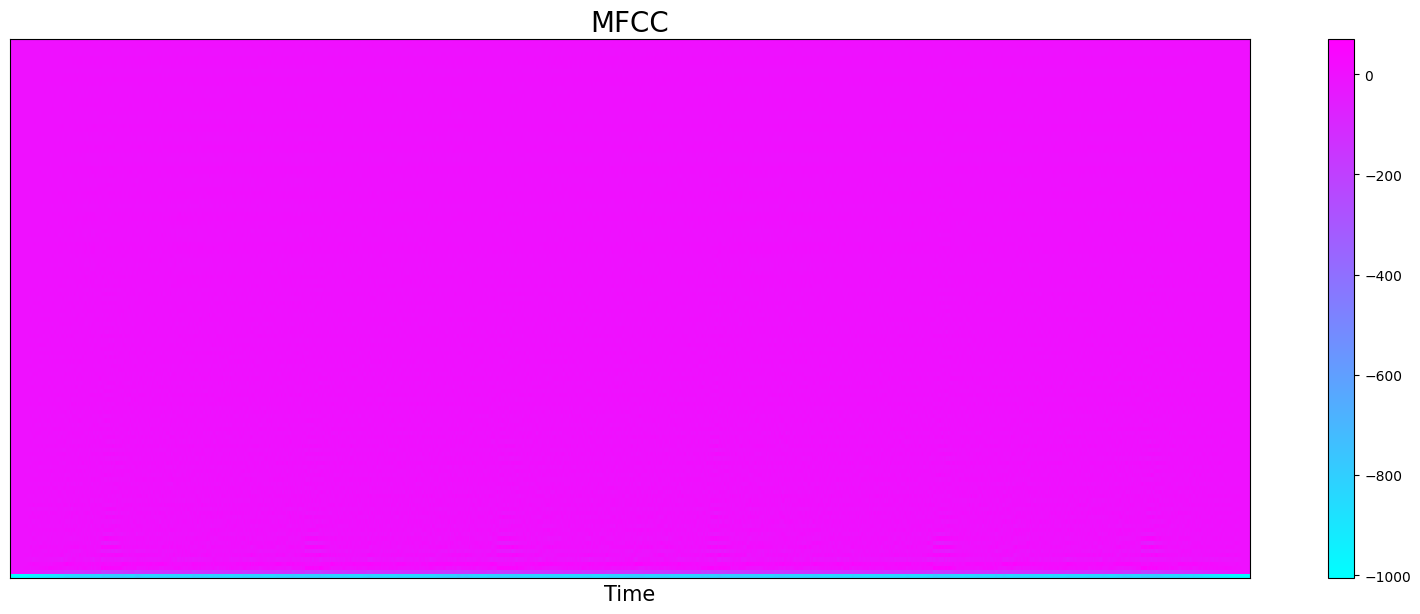

In [5]:
hop_length = 512 #the default spacing between frames
n_fft = 255 #number of samples 
#cut the sample to the relevant times
#y_cut=y[int(round(tstart*sr)):int(round(tend*sr))]
MFCCs = librosa.feature.mfcc(y=audio, n_fft=n_fft,hop_length=hop_length,n_mfcc=128)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool',hop_length=hop_length)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

#### Extract features from all files

In [6]:
print(len(df))

24459


In [7]:
def get_features(df):
    num_samples = len(df)
    mfcc_features = CFG.mfcc_features
    mfcc_length = CFG.mfcc_length


    features = np.zeros((num_samples, mfcc_features, mfcc_length))
    labels = []

    for index in range(num_samples):      
        path = df.iloc[index].filepath
        label = df.iloc[index].target

        audio, sr = librosa.load(path)

        # Extract MFCC features
        data = librosa.feature.mfcc(y=audio, n_fft=n_fft, hop_length=hop_length, n_mfcc=mfcc_features) 
        
        # Pad or truncate MFCC to fixed_length
        if data.shape[1] < mfcc_length:
            # Pad with zeros
            padding = np.zeros((mfcc_features, mfcc_length - data.shape[1]))
            data = np.hstack((data, padding))
        else:
            # Truncate
            data = data[:, :mfcc_length]

        # Add the processed feature to the preallocated array
        features[index] = data
        labels.append(label)

    # One-Hot Encode the labels
    labels = to_categorical(labels, num_classes=CFG.num_classes)
    return features, labels

# Define fixed length
X, y = get_features(df)

In [8]:
# TODO: Normalize
# Note kernel crash: not enough memory
#X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
#X = X/np.std(X)
#y = np.array(y)

In [9]:
X.shape, y.shape

((24459, 64, 1000), (24459, 182))

#### Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=CFG.random_seed, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=CFG.random_seed, stratify=y_train)


X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((17671, 64, 1000),
 (3119, 64, 1000),
 (3669, 64, 1000),
 (17671, 182),
 (3119, 182),
 (3669, 182))

### RNN Model & Training

#### Create model architecture

In [11]:
input_shape=(64,1000)
model = keras.Sequential()

model.add(Input(shape=input_shape))
model.add(LayerNormalization(axis=-1))

model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))
model.add(LayerNormalization(axis=-1))

model.add(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))
model.add(LayerNormalization(axis=-1))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))

model.add(Dense(CFG.num_classes, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ (None, 64, 1000)       │         2,000 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64, 256)        │     1,287,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 64, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 182)            │        23,478 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,527,558 (5.83 MB)

 Trainable params: 1,527,302 (5.83 MB)

 Non-trainable params: 256 (1.00 KB)

#### Compile and run model

In [20]:
def step_decay(epoch):
    # Halves every 10 epochs
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    return initial_lr * (drop ** (epoch // epochs_drop))

lr_schedule = LearningRateScheduler(step_decay)
opt = Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), shuffle=False, callbacks=[lr_schedule])

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 71s 249ms/step - acc: 0.0291 - loss: 25.1809 - val_acc: 0.0321 - val_loss: 17.1809 - learning_rate: 0.0100
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 64s 233ms/step - acc: 0.0289 - loss: 20.1906 - val_acc: 0.0260 - val_loss: 26.5509 - learning_rate: 0.0100
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 65s 235ms/step - acc: 0.0243 - loss: 20.9975 - val_acc: 0.0205 - val_loss: 16.2104 - learning_rate: 0.0100
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 65s 234ms/step - acc: 0.0213 - loss: 13.7118 - val_acc: 0.0205 - val_loss: 6.6304 - learning_rate: 0.0100
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 63s 229ms/step - acc: 0.0188 - loss: 6.1544 - val_acc: 0.0205 - val_loss: 5.2747 - learning_rate: 0.0100
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 65s 236ms/step - acc: 0.0187 - loss: 5.1831 - val_acc: 0.0205 - val_loss: 4.9055 - learning_rate: 0.0100
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 63s 228ms/step - acc: 0.0187 - loss: 18.7889 - val_acc: 0.0205 - val_loss: 15.6386 

KeyboardInterrupt: 

Unfortunately the model was unable to converge with higher learning rates.

### Evaluate and plot results

In [ ]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_acc']
epochs=range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1)))